In [1]:
import numpy as np
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plotly.offline.init_notebook_mode(connected=True)

In [12]:
def gaussian_line(x, A, x0, std):
    return A * (np.exp(-(x-x0)**2 /std ))

def create_spectrum(line_list):
    spectrum = np.zeros(line_list[0].shape)
    for line in line_list:
        spectrum += line
    return spectrum

def get_bin_shift(x, time_shift):
    return np.where(x >= time_shift)[0][0]

def shift_spectrum(x, y, shift, n_shifts = 1, decay = 0.3):
    x = np.array(x)
    shifted_spectrum = y.copy()
    bin_shift = get_bin_shift(x, shift) 
    for n in range(1, n_shifts+1):
        y_new = np.roll(y, n * bin_shift)
        shifted_spectrum += decay * y_new
    return shifted_spectrum, bin_shift

def get_measurements(t, spectrum, time_shift, samples = 10):
    X = []
    bins = spectrum.shape[0]
    for sample in range(samples):
        sample_spectrum, bin_shift = shift_spectrum(t, spectrum, time_shift, n_shifts = 4)
        sample_spectrum += np.abs(np.random.normal(0, 0.2, bins))
        X.append(sample_spectrum)
    X = np.array(X)
    return X, bin_shift

In [3]:
bins = 100
time_shift = 100

t = np.linspace(0, 500, bins)
y1 = gaussian_line(t, 10, 173, 10)
y2 = gaussian_line(t, 2, 147, 10)
y3 = gaussian_line(t, 7, 202, 7)
spectrum = create_spectrum([y1, y2, y3])

samples, bin_shift = get_measurements(t, spectrum, time_shift = 100, samples = 50)


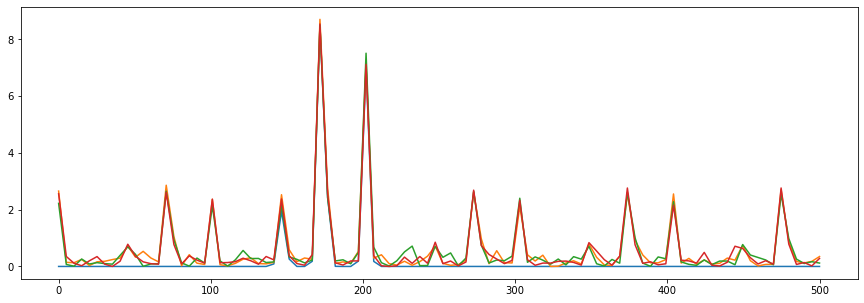

In [4]:
fig = plt.figure(figsize = (15,5))
plt.plot(t, spectrum)
plt.plot(t, samples[0,:])
plt.plot(t, samples[1,:])
plt.plot(t, samples[10,:])
plt.show()

Shift matrix is defined as the matrix that repeats the signal with a given intensity weight according to:

$Y = MX_{original}$,
where
$ M = W\circ A$,
is the shift matrix defined by a multiplication of the weight matrix, $W$, and the repetition matrix, $A$.

In [5]:
def get_shift_matrix(t, spectrum, time_shifts, decay_weight):
    bins = spectrum.shape[0]
    shift_matrix = np.eye(bins)
    
    bin_shifts = []
    for time_shift in time_shifts:
        bin_shifts.append(get_bin_shift(t, time_shift))
    
    for shift in bin_shifts:
        for bin in range(bins):
            iter_bin = bin
            while iter_bin + shift < bins:
                shift_matrix[bin, iter_bin + shift] += decay_weight
                iter_bin += shift
    shift_matrix += shift_matrix.T
    np.fill_diagonal(shift_matrix, 1)
    return shift_matrix

M = get_shift_matrix(t, spectrum, time_shifts = [time_shift], decay_weight = 0.3)



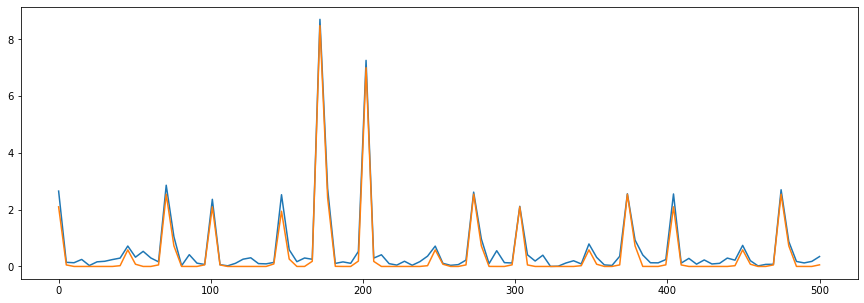

In [6]:
plt.figure(figsize = (15,5))
plt.plot(t, samples[0,:])
plt.plot(t, np.dot(M, spectrum.T), '-')
plt.show()

The original signal $X_{original}$ is retrieved by computing the inverse

$X_{original} = M^{-1} Y$.

In [7]:
M_inv = np.linalg.pinv(M)
test_spec = np.dot(M_inv, samples[0,:])

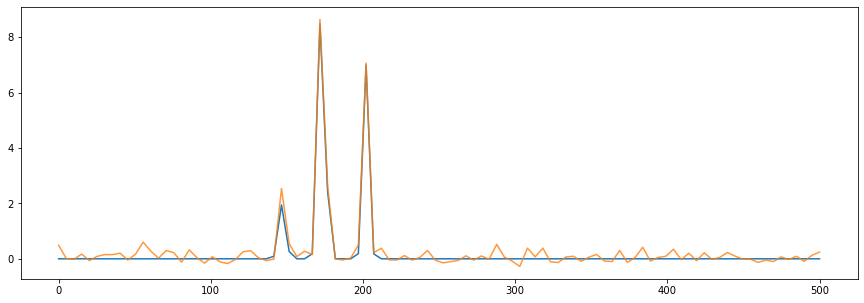

In [11]:
plt.figure(figsize = (15,5))
plt.plot(t, spectrum)
plt.plot(t, test_spec, '-', alpha = 0.8)
plt.show()